In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [60]:
import numpy as np
import pandas as pd
import datetime as dt
import scipy

# Reflect Tables into SQLAlchemy ORM

In [20]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
import datetime as dt

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [21]:
#Finding my columns with the inspector
inspector = inspect(engine)
measurement_columns = inspector.get_columns('measurement')
for c in measurement_columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [19]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
most_recent_date

('2017-08-23',)

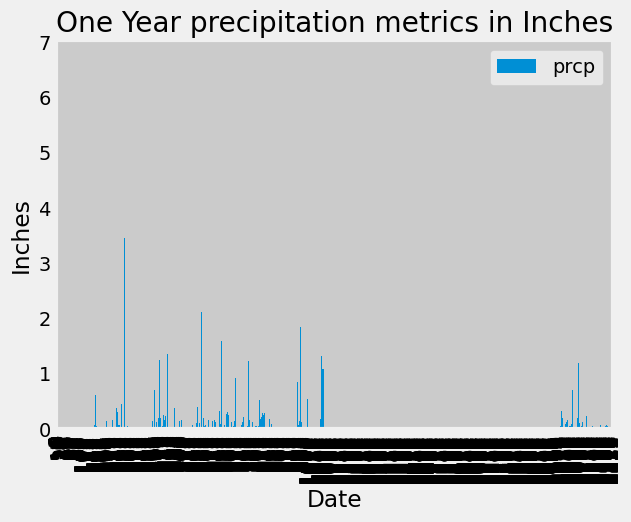

In [87]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores

last_12_months = session.query(measurement.date, measurement.prcp)\
                .filter((measurement.date < '2017-08-23')&(measurement.date >=(dt.date(2017,8,23)-dt.timedelta(days=365)))).\
                order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names

df = pd.DataFrame(last_12_months)
# Sort the dataframe by date

sorted_df = df.sort_values(['date'])
# Use Pandas Plotting with Matplotlib to plot the data

#sorted_df.plot(kind='bar')
sorted_df.plot(kind='bar')
plt.title('One Year precipitation metrics in Inches')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.show()

In [76]:
# Use Pandas to calculate the summary statistics for the precipitation data
stats = df.describe()
stats

,prcp
count,2017.000000
mean,0.177367
std,0.461568
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [22]:
station_columns = inspector.get_columns('measurement')
for c in station_columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [94]:
# Design a query to calculate the total number of stations in the dataset
count = session.query(station).count()
count

9

In [111]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
stations = session.query(station.station).group_by(station.station).order_by(station.station).all()
stations

[('USC00511918',),
 ('USC00513117',),
 ('USC00514830',),
 ('USC00516128',),
 ('USC00517948',),
 ('USC00518838',),
 ('USC00519281',),
 ('USC00519397',),
 ('USC00519523',)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


[(54.0, 85.0, 71.66378066378067)]

Text(0.5, 4.183333333333314, 'Temperature')

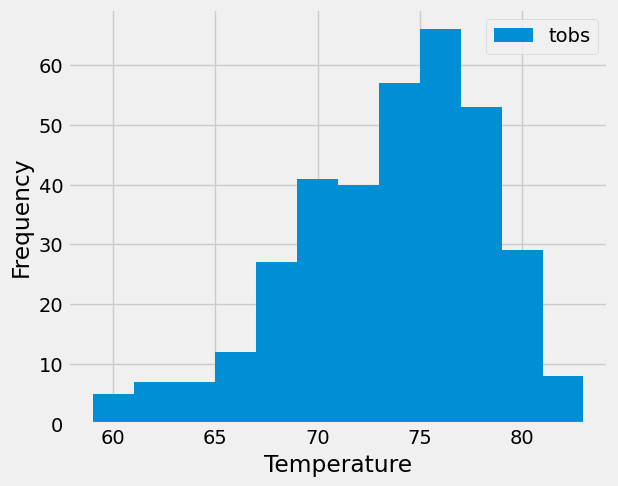

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close Session

In [16]:
# Close Session
session.close()